# Using the tf.data.Dataset

In Tensorflow 2.0 it's good practice to load your data using the `tf.data.Dataset` API. However, using this isn't always straightforward. There are multiple ways you can create such a dataset. In this article we will look at several of them. 

For all of these methods we will use the same model and parameters. 


In [1]:
import tensorflow as tf
import numpy as np
import sklearn.metrics

print("The TensorFlow version used in this tutorial is", tf.__version__)

def get_and_compile_model():
    # Define a very simple model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(28,28)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128,activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    # Print the summary of the neural network
    model.summary()

    # Compile the model. You always have to do that after quantizing your weights. 
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(0.001),
        metrics=['accuracy'],
    )
    return model

#load mnist data we will need in the entirety of this notebook
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0 

BATCH_SIZE = 32
STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE # Note that // means full division without any remainder. It rounds down and becomes an integer

The TensorFlow version used in this tutorial is 2.2.0


## Method 0: Directly feeding a NumPy array
Currently, with Keras, it's still possible to directly feed NumPy arrays. 

In [2]:
#load mnist data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Train for one epoch to establish a baseline. 
model = get_and_compile_model()
model.fit(x_train / 255.0, y_train, batch_size=BATCH_SIZE, epochs=3)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2563 - accuracy: 0.9262
Epoch 2/3
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1138 - accuracy: 0.9663
Epoch 3/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0787 - accuracy: 0.9766


## Method 1: From a numpy array
If your data fits in your memory it's easy to turn your numpy array into a dataset. Having your data in a dataset is also one of the fastest ways to load the data. 

A common error to get here is `ValueError: When providing an infinite dataset, you must specify the number of steps to run.`. Make sure you specify this by setting `steps_per_epoch` to the number of batches you want to supply during training. Normally this number of batches should roughly cover the entire dataset.

In [3]:
# Create the tf.data.Dataset from the existing data
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

# By default you 'run out of data', this is why you repeat the dataset and serve data in batches. 
dataset = dataset.repeat().batch(BATCH_SIZE)

# Train for one epoch to verify this works. 
model = get_and_compile_model()
model.fit(dataset,steps_per_epoch=STEPS_PER_EPOCH )


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
1875/1875 [==============================] - 5s 2ms/step - loss: 2.3345 - accuracy: 0.8567


## Method 2: Using a generator
If you still have to load or adjust data it's easy to create a generator which becomes a dataset. 

A common error to get here is `ValueError: When providing an infinite dataset, you must specify the number of steps to run.`. Make sure you specify this by setting `steps_per_epoch` to the number of batches you want to supply during training. Normally this number of batches should roughly cover the entire dataset.

Another common error is `TypeError: 'generator' must be callable.`. When creating a generator you can't pass anything to this generator. This requires a bit of Python puzzling to realize that you can pass the arguments to a function, which then creates an argument-free generator inside this function with the arguments you passed to the first function. The result can be seen below. 

In [4]:
# Create the argument-free generator as function inside a function with arguments. 
def create_dataset_generator(inputs, labels):
    def argument_free_generator():
        for inp, label in zip(inputs, labels):
            yield inp, label
    return argument_free_generator

# Create the generator which yields inputs and outputs
generator = create_dataset_generator(x_train, y_train)

# Create the tf.data.Dataset from this generator and specify the types and shapes of the data. 
dataset = tf.data.Dataset.from_generator(generator, (tf.float32, tf.int32), ((28,28 ), ()))

# By default you 'run out of data', this is why you repeat the dataset and serve data in batches. 
dataset = dataset.repeat().batch(BATCH_SIZE)

# Train for one epoch to verify this works. 
model = get_and_compile_model()
model.fit(dataset,steps_per_epoch=STEPS_PER_EPOCH )


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
1875/1875 [==============================] - 22s 12ms/step - loss: 2.5669 - accuracy: 0.8523


## Verifying your dataset
It's a bit hard to verify that your dataset is still working as expected. Luckily there are methods, such as `dataset.as_numpy_iterator` which allow you to inspect and verify your data. Here is an example on how to use this:

Input shape is: (32, 28, 28) output shape is: (32,)


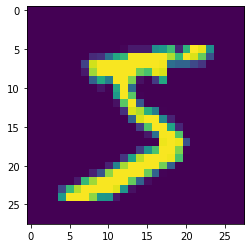

label of this input is 5


In [5]:
import matplotlib.pyplot as plt

for inputs, outputs in dataset.as_numpy_iterator():
    # Verify the shapes are still as we expect
    print("Input shape is:", inputs.shape, "output shape is:", outputs.shape)

    # Print the first element and the label
    plt.imshow(inputs[0,:])
    plt.show()
    print('label of this input is', outputs[0])
    
    # Break now. We only want to visualise the first example
    break

## Split the dataset into a train and test set. 
Sometimes you don't have a clear train and test set, or you want to train with only a subset of your training data and use the rest to validate your initial approach. 

Note that when supplieing any dataset you have to give the length, otherwise you get a `ValueError: When providing an infinite dataset, you must specify the number of steps to run.` message. 


In [13]:
# Create the tf.data.Dataset from the existing data
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

# Split the data into a train and a test set.
SAMPLES_TRAINING = int(len(x_train)*0.8)
train_dataset = dataset.take(SAMPLES_TRAINING)
test_dataset = dataset.skip(SAMPLES_TRAINING)

# Both datasets have to be repeated and batched appropriately
train_dataset = train_dataset.repeat().batch(BATCH_SIZE)
test_dataset = test_dataset.repeat().batch(BATCH_SIZE)


# Train for one epoch to verify this works. Note you now have to adjust the steps_per_epoch to reflect the new dataset. 
model = get_and_compile_model()
model.fit(train_dataset,
          validation_data=test_dataset,
          steps_per_epoch=(len(x_train)*0.8)//BATCH_SIZE, 
          validation_steps= (len(x_train)*0.2)//BATCH_SIZE)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_13 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
1500/1500 [==============================] - 5s 3ms/step - loss: 2.5344 - accuracy: 0.8323 - val_loss: 0.4840 - val_accuracy: 0.8849


## Conclusion
You now saw two examples on how to load data into the tf.data.Dataset format. You hopefully also noticed that having data in memory is faster than having the data being loaded by a generator. 
The examples in this Jupyter Notebook showed you how to properly combine TensorFlows Dataset API and Keras. You now also know how to split a tf.data.Dataset into a train and a test set. 

